## Import Libraries and Configure Notebook

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Constants
RANDOM = 1992

/kaggle/input/playground-series-s4e2/sample_submission.csv
/kaggle/input/playground-series-s4e2/train.csv
/kaggle/input/playground-series-s4e2/test.csv


In [2]:
# Color Palettes
colors = {
    "sage"     : "#53808D",
    "orange"   : "#FC4C02",
    "blue"     : "#1B99D6",
    "yellow"   : "#FFF57B",
    "darkgrey" : "#585858",
    "lightgrey": "#D5DADD",
    "lightsage": '#E9F2EF'
}
palette_discete = sns.color_palette([v for k,v in colors.items()])
palette_continuous = sns.color_palette(f"blend:{colors['sage']},{colors['orange']}", as_cmap=True) 

# custom theme
rc = {
    'axes.facecolor':f"{colors['lightsage']}",
    "axes.edgecolor":f"{colors['sage']}",
    "text.color":f"{colors['sage']}",
    "axes.labelcolor":f"{colors['sage']}",
    "ytick.color":f"{colors['sage']}",
    "xtick.color":f"{colors['sage']}",
}
sns.set_style('whitegrid',rc =rc)

# set context elements
sns.set_context('notebook',rc={'grid.linewidth':'1.1'})

# set custom palette
sns.set_palette(palette_discete)

palette_discete



[(0.3254901960784314, 0.5019607843137255, 0.5529411764705883),
 (0.9882352941176471, 0.2980392156862745, 0.00784313725490196),
 (0.10588235294117647, 0.6, 0.8392156862745098),
 (1.0, 0.9607843137254902, 0.4823529411764706),
 (0.34509803921568627, 0.34509803921568627, 0.34509803921568627),
 (0.8352941176470589, 0.8549019607843137, 0.8666666666666667),
 (0.9137254901960784, 0.9490196078431372, 0.9372549019607843)]

## Data Descriptions

The attributes related with eating habits are: 
+ Frequent consumption of high caloric food (FAVC)
+ Frequency of consumption of vegetables (FCVC)
+ Number of main meals (NCP)
+ Consumption of food between meals (CAEC) => Ordinal  (always, frequently, sometimes, no=never)
+ Consumption of water daily (CH20)
+ Consumption of alcohol (CALC) => Ordinal (frequently, sometimes, no=never)

The attributes related with the physical condition are: 
+ Calories consumption monitoring (SCC)
+ Physical activity frequency (FAF)
+ Time using technology devices (TUE)
+ Transportation used (MTRANS)

variables obtained
+ Gender
+ Age
+ Height
+ Weight

NObesity values are

+ Insufficient_Weight Less than 18.5
+ Normal_Weight 18.5 to 24.9
+ Overweight 25.0 to 29.9
+ Obesity_Type_I 30.0 to 34.9
+ Obesity_Type_II 35.0 to 39.9
+ Obesity_Type_III Higher than 40

In [3]:
def get_data():
    """"""
    train= pd.read_csv("/kaggle/input/playground-series-s4e2/train.csv")
    test = pd.read_csv("/kaggle/input/playground-series-s4e2/test.csv")
    
    # category features 
    cols = ['Gender','CAEC','CALC','MTRANS','NObeyesdad']
    for col in cols:
        try:
            train[col] = train[col].apply(lambda x: x.lower().strip()).astype('category')
            test[col] = test[col].apply(lambda x: x.lower().strip()).astype('category')
        except:
            # test data doesn't have NObeyesdad
            continue
            
    # bindary features
    cols = ['family_history_with_overweight','FAVC','SMOKE','SCC']
    for col in cols:
        train[col] = train[col].map({'yes':1,'no':0}).astype('uint8')
        test[col] = test[col].map({'yes':1,'no':0}).astype('uint8')
        
    # rename columns
    train.rename(columns = {'family_history_with_overweight':'FamiliyHistory','NObeyesdad':'Target'},inplace=True)
    test.rename(columns = {'family_history_with_overweight':'FamiliyHistory'},inplace=True)
    
    return train, test


# get the raw data
train, test = get_data()

# cols_category = ['Gender','CAEC','CALC','MTRANS','Target']
# cols_ordinal = ['CAEC','CALC']
# cols_numeric =['Height','Weight','FCVC','NCP','CH2O','FAF','TUE','Target']
# cols_binary = ['FamilyHistory','FAVC','SMOKE','SCC','Target']

train


,id,Gender,Age,Height,Weight,FamiliyHistory,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Target
0,0,male,24.443011,1.699998,81.669950,1,1,2.000000,2.983297,sometimes,0,2.763573,0,0.000000,0.976473,sometimes,public_transportation,overweight_level_ii
1,1,female,18.000000,1.560000,57.000000,1,1,2.000000,3.000000,frequently,0,2.000000,0,1.000000,1.000000,no,automobile,normal_weight
2,2,female,18.000000,1.711460,50.165754,1,1,1.880534,1.411685,sometimes,0,1.910378,0,0.866045,1.673584,no,public_transportation,insufficient_weight
3,3,female,20.952737,1.710730,131.274851,1,1,3.000000,3.000000,sometimes,0,1.674061,0,1.467863,0.780199,sometimes,public_transportation,obesity_type_iii
4,4,male,31.641081,1.914186,93.798055,1,1,2.679664,1.971472,sometimes,0,1.979848,0,1.967973,0.931721,sometimes,public_transportation,overweight_level_ii
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,20753,male,25.137087,1.766626,114.187096,1,1,2.919584,3.000000,sometimes,0,2.151809,0,1.330519,0.196680,sometimes,public_transportation,obesity_type_ii
20754,20754,male,18.000000,1.710000,50.000000,0,1,3.000000,4.000000,frequently,0,1.000000,0,2.000000,1.000000,sometimes,public_transportation,insufficient_weight
20755,20755,male,20.101026,1.819557,105.580491,1,1,2.407817,3.000000,sometimes,0,2.000000,0,1.158040,1.198439,no,public_transportation,obesity_type_ii
20756,20756,male,33.852953,1.700000,83.520113,1,1,2.671238,1.971472,sometimes,0,2.144838,0,0.000000,0.973834,no,automobile,overweight_level_ii


In [4]:
def add_features(df):
    """"""
    dff = df.copy()
    
    # body-mass-index
    dff['BMI'] = dff['Weight'] / dff['Height']**2
    
    # physical transportation
    dff['TransPhysical'] = dff['MTRANS'].apply(lambda x: 1 if  x=='walking' or x=='bike' else 0)
    
    
    return dff
train = add_features(train)
test = add_features(test)

In [5]:

# ordinal encoder
oe = OrdinalEncoder(categories = [['always','frequently','sometimes','no'],['always','frequently','sometimes','no']])

# encode ordinals
cols_ordinal = ['CAEC','CALC']
train[cols_ordinal] = oe.fit_transform(train[cols_ordinal])
test[cols_ordinal] = oe.fit_transform(test[cols_ordinal])


In [6]:
# one-hot encode categoricals
cols_category = ['Gender','MTRANS']

# one-hot-encoder
ohe = OneHotEncoder(sparse=False)

# train
ohe_features = pd.DataFrame(ohe.fit_transform(train[cols_category]),columns = ohe.get_feature_names_out())
train = pd.concat([train,ohe_features],axis=1)
train.drop(columns=cols_category,inplace=True)

# test
ohe_features = pd.DataFrame(ohe.fit_transform(test[cols_category]),columns = ohe.get_feature_names_out())
test = pd.concat([test,ohe_features],axis=1)
test.drop(columns=cols_category,inplace=True)






In [7]:
train.head()

,id,Age,Height,Weight,FamiliyHistory,FAVC,FCVC,NCP,CAEC,SMOKE,...,Target,BMI,TransPhysical,Gender_female,Gender_male,MTRANS_automobile,MTRANS_bike,MTRANS_motorbike,MTRANS_public_transportation,MTRANS_walking
0,0,24.443011,1.699998,81.669950,1,1,2.000000,2.983297,2.0,0,...,overweight_level_ii,28.259565,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1,18.000000,1.560000,57.000000,1,1,2.000000,3.000000,1.0,0,...,normal_weight,23.422091,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2,18.000000,1.711460,50.165754,1,1,1.880534,1.411685,2.0,0,...,insufficient_weight,17.126706,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,3,20.952737,1.710730,131.274851,1,1,3.000000,3.000000,2.0,0,...,obesity_type_iii,44.855798,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,4,31.641081,1.914186,93.798055,1,1,2.679664,1.971472,2.0,0,...,overweight_level_ii,25.599151,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [8]:
test.head()

,id,Age,Height,Weight,FamiliyHistory,FAVC,FCVC,NCP,CAEC,SMOKE,...,CALC,BMI,TransPhysical,Gender_female,Gender_male,MTRANS_automobile,MTRANS_bike,MTRANS_motorbike,MTRANS_public_transportation,MTRANS_walking
0,20758,26.899886,1.848294,120.644178,1,1,2.938616,3.000000,2.0,0,...,2.0,35.315411,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,20759,21.000000,1.600000,66.000000,1,1,2.000000,1.000000,2.0,0,...,2.0,25.781250,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,20760,26.000000,1.643355,111.600553,1,1,3.000000,3.000000,2.0,0,...,2.0,41.324115,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,20761,20.979254,1.553127,103.669116,1,1,2.000000,2.977909,2.0,0,...,2.0,42.976937,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,20762,26.000000,1.627396,104.835346,1,1,3.000000,3.000000,2.0,0,...,2.0,39.584143,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


<Axes: xlabel='BMI', ylabel='Target'>

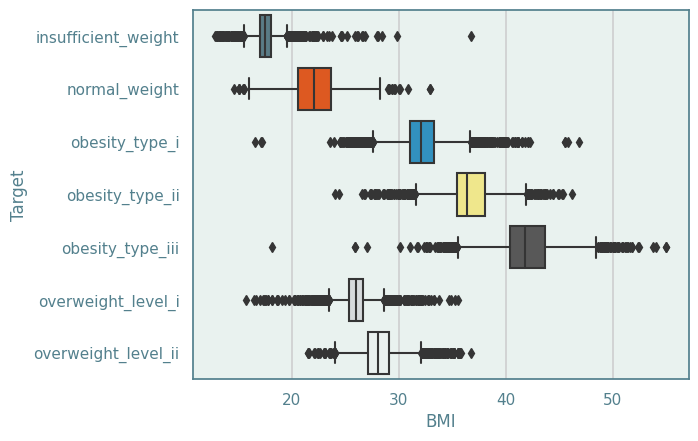

In [9]:

# sns.relplot(data=train, kind='scatter',hue='Gender',y='Height',x='Weight',col='Target')

# sns.boxplot(data=train,x='Age',y='Target')
# sns.boxplot(data=train,x='Height',y='Target')
# sns.boxplot(data=train,x='Weight',y='Target')
sns.boxplot(data=train,x='BMI',y='Target')

# sns.pairplot(data=train[cols_numeric], hue='Target')


In [10]:
# from ydata_profiling import ProfileReport
# ProfileReport(train)